In [60]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
"""
Graph mining links and examples:

https://github.com/RISHIKESHAVAN/link-prediction/blob/main/code/citation-network.ipynb

https://github.com/topics/graph-mining?o=asc&s=stars

https://github.com/topics/graph-mining
"""

In [2]:
#data sets to load
crash_data = gpd.read_file('data/act_crash_data.geojson')
merged_data = gpd.read_file('data/merged.geojson')
roundabouts_data = gpd.read_file('data/roundabout.geojson')

Data Loading and Filtering for accident/DDB points at roundabouts only

In [3]:
crash_data.head()

,CRASH_ID,CRASH_DATE,CRASH_TIME,SUBURB_LOCATION,LONGITUDE,LATITUDE,INTERSECTION,MIDBLOCK,CRASH_DIRECTION,CRASH_SEVERITY,LIGHTING_CONDITION,ROAD_CONDITION,WEATHER_CONDITION,Location,geometry
0,1025691,13/01/2012,09:18:00,KAMBAH,149.055056,-35.392007,NO,YES,East bound,Injury,Daylight,Good dry surface,Fine,"(-35.392006654135606, 149.05505612950844)",POINT (149.05506 -35.39201)
1,1039779,05/04/2012,17:30:00,PHILLIP,149.084447,-35.348921,YES,NO,West bound,Injury,Daylight,Good dry surface,Fine,"(-35.34892137433122, 149.0844465057644)",POINT (149.08445 -35.34892)
2,1048742,28/10/2012,11:48:00,HALL,149.061431,-35.172863,NO,YES,South bound,Injury,Daylight,Good dry surface,Fine,"(-35.172862707340954, 149.0614313347401)",POINT (149.06143 -35.17286)
3,1041937,07/08/2012,17:00:00,BELCONNEN,149.094072,-35.201315,YES,NO,North bound,Property Damage Only,Daylight,Good dry surface,Fine,"(-35.201315499751615, 149.09407196860244)",POINT (149.09407 -35.20132)
4,1048339,01/11/2012,14:45:00,HARRISON,149.156400,-35.197308,YES,NO,South bound,Injury,Daylight,Good dry surface,Fine,"(-35.19730828458103, 149.15639997910796)",POINT (149.15640 -35.19731)


In [4]:
crash_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
crash_data = crash_data.to_crs(3857)
crash_data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
merged_data.head()

,timestamp,xacc,yacc,speed,maxspeed,lanecount,classification,geometry
0,2022-01-03 01:49:36+00:00,-0.622,-0.255,29,62,1,Braking,POINT (149.00200 -35.76227)
1,2020-07-01 02:17:01+00:00,1.394,-0.600,64,83,4,Steering,POINT (149.05411 -35.32600)
2,2023-01-25 06:32:38+00:00,-1.114,0.017,27,48,2,Braking,POINT (149.06319 -35.32026)
3,2021-06-23 07:33:19+00:00,-0.976,0.396,17,22,1,Braking,POINT (149.06277 -35.32006)
4,2021-03-03 21:55:16+00:00,-0.896,0.003,67,95,2,Braking,POINT (149.06238 -35.31332)


In [7]:
merged_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
merged_data = merged_data.to_crs(3857)
merged_data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
roundabouts_data = roundabouts_data[['geometry']]
roundabouts_data

,geometry
0,"POLYGON ((149.02752 -35.20240, 149.02752 -35.2..."
1,"POLYGON ((149.03340 -35.20588, 149.03338 -35.2..."
2,"POLYGON ((149.02890 -35.19941, 149.02891 -35.1..."
3,"POLYGON ((149.02712 -35.20537, 149.02708 -35.2..."
4,"LINESTRING (149.16504 -35.22496, 149.16497 -35..."
...,...
899,"LINESTRING (149.14601 -35.24354, 149.14602 -35..."
900,"LINESTRING (149.14610 -35.24351, 149.14610 -35..."
901,"LINESTRING (149.08657 -35.33668, 149.08649 -35..."
902,"LINESTRING (149.15659 -35.20972, 149.15668 -35..."


In [10]:
roundabouts_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
roundabouts_data = roundabouts_data.to_crs(3857)
roundabouts_data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
#spatial join for DDB to roundabouts
ddb_roundabout = gpd.sjoin_nearest(merged_data, roundabouts_data, max_distance=100, distance_col='distances', how='left')

In [14]:
ddb_roundabout = ddb_roundabout[~ddb_roundabout['distances'].isna()]

In [15]:
ddb_roundabout.head()

,timestamp,xacc,yacc,speed,maxspeed,lanecount,classification,geometry,index_right,distances
7,2020-12-17 01:46:30+00:00,-0.889,0.002,7,32,1,Braking,POINT (16595825.835 -4208110.694),402.0,78.508285
9,2020-07-05 23:53:50+00:00,-0.864,0.000,3,48,1,Braking,POINT (16597539.710 -4206559.210),70.0,27.548220
9,2020-07-05 23:53:50+00:00,-0.864,0.000,3,48,1,Braking,POINT (16597539.710 -4206559.210),903.0,27.548220
20,2020-04-25 19:27:59+00:00,-0.346,0.714,27,45,1,Steering,POINT (16597536.370 -4206536.837),70.0,4.927812
20,2020-04-25 19:27:59+00:00,-0.346,0.714,27,45,1,Steering,POINT (16597536.370 -4206536.837),903.0,4.927812


In [16]:
#spatial join for crash data to roundabouts
crash_roundabout = gpd.sjoin_nearest(crash_data, roundabouts_data, max_distance=100, distance_col='distances', how='left')

In [18]:
crash_roundabout = crash_roundabout[~crash_roundabout['distances'].isna()]

In [19]:
crash_roundabout.head()

,CRASH_ID,CRASH_DATE,CRASH_TIME,SUBURB_LOCATION,LONGITUDE,LATITUDE,INTERSECTION,MIDBLOCK,CRASH_DIRECTION,CRASH_SEVERITY,LIGHTING_CONDITION,ROAD_CONDITION,WEATHER_CONDITION,Location,geometry,index_right,distances
8,1082208,14/03/2014,14:45:00,WANNIASSA,149.105038,-35.394988,YES,NO,North bound,Property Damage Only,Daylight,Good dry surface,Fine,"(-35.394987516718835, 149.1050382804053)",POINT (16598296.938 -4217688.770),124.0,54.232167
9,1071548,25/09/2013,09:15:00,PARKES,149.140739,-35.290364,YES,NO,South bound,Injury,Daylight,Good dry surface,Fine,"(-35.2903638694626, 149.14073893625283)",POINT (16602271.111 -4203410.781),598.0,18.107638
12,1097139,21/10/2014,12:50:00,WESTON,149.052234,-35.342376,YES,NO,South / West bound,Injury,Daylight,Good dry surface,Fine,"(-35.342376051736125, 149.05223439721874)",POINT (16592418.835 -4210506.572),109.0,52.375484
21,1101688,18/12/2014,15:00:00,CURTIN,149.085469,-35.336601,YES,NO,North bound,Property Damage Only,Daylight,Good dry surface,Fine,"(-35.33660063969841, 149.08546898336647)",POINT (16596118.494 -4209718.433),302.0,37.911366
30,1116903,04/08/2015,07:10:00,CURTIN,149.085534,-35.336096,YES,NO,North / East bound,Injury,Daylight,Good dry surface,Fine,"(-35.336095898518856, 149.0855345007159)",POINT (16596125.785 -4209649.556),302.0,1.119271


In [25]:
crash_roundabout = crash_roundabout.drop(columns='CRASH_ID')

In [ ]:
#export data ddb
#ddb_roundabout.to_file('data/ddb_roundabout.geojson', driver='GeoJSON')

In [ ]:
#export data crash
#crash_roundabout.to_file('data/crash_roundabout.geojson', driver='GeoJSON')

Graph Construction DDB

In [28]:
#Create empty graph
G = nx.Graph()

In [38]:
# Calculate the minimum and maximum x-acceleration and y-acceleration values
max_x, min_x, max_y, min_y = -1, float('inf'), -1, float('inf')
print(f"Minimum x-acceleration: {min_x}")
print(f"Maximum x-acceleration: {max_x}")
print(f"Minimum y-acceleration: {min_y}")
print(f"Maximum y-acceleration: {max_y}")

Minimum x-acceleration: inf
Maximum x-acceleration: -1
Minimum y-acceleration: inf
Maximum y-acceleration: -1


In [49]:
#iterate ddb roundabout dataset for nodes and metric
for index, row in ddb_roundabout.iterrows():
    # Calculate the minimum and maximum x-acceleration and y-acceleration values
    max_x = max(max_x, row['xacc'])
    min_x = min(min_x, row['xacc'])
    max_y = max(max_y, row['yacc'])
    min_y = min(min_y, row['yacc'])

    #add nodes to graph
    location = row['geometry']
    x_acc = row['xacc']
    y_acc = row['yacc']

    G.add_node(location) 
    G.nodes[location]['xacc'] = x_acc
    G.nodes[location]['yacc'] = y_acc

In [50]:
G

In [51]:
print(f"Minimum x-acceleration: {min_x}")
print(f"Maximum x-acceleration: {max_x}")
print(f"Minimum y-acceleration: {min_y}")
print(f"Maximum y-acceleration: {max_y}")

Minimum x-acceleration: -1.962
Maximum x-acceleration: 1.116
Minimum y-acceleration: -1.096
Maximum y-acceleration: 0.957


In [63]:
#Similarity Metric
def calculate_similarity(node1, node2, max_x, min_x, max_y, min_y):
    # Extract feature values from nodes (locations)
    x1 = G.nodes[node1]['xacc']
    y1 = G.nodes[node1]['yacc']
    
    x2 = G.nodes[node2]['xacc']
    y2 = G.nodes[node2]['yacc']
    
    # Calculate Euclidean distance between feature vectors
    euclidean_distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    # Normalize the distance to a similarity score (higher values indicate more similarity)
    max_possible_distance = np.sqrt((max_x - min_x)**2 + (max_y - min_y)**2)  # Adjust as needed
    similarity_score = 1 - (euclidean_distance / max_possible_distance)
    
    return similarity_score

In [53]:
for node in G.nodes():
    print(node)

POINT (16595825.834815076 -4208110.694462051)
POINT (16597539.709695332 -4206559.2101193825)
POINT (16597536.370110609 -4206536.8371608285)
POINT (16597543.160599545 -4207490.320120027)
POINT (16597551.620880844 -4207244.608588769)
POINT (16597527.798509814 -4206547.205111591)
POINT (16597539.709695332 -4206546.659429728)
POINT (16596671.19502816 -4206458.941421252)
POINT (16593495.361275319 -4209304.197992779)
POINT (16597512.547739578 -4206532.608131078)
POINT (16597543.160599545 -4206512.963627034)
POINT (16596700.583373731 -4206458.805001875)
POINT (16595778.301392509 -4207938.372336179)
POINT (16597543.160599545 -4206591.951116112)
POINT (16597554.96046557 -4206520.7395723695)
POINT (16597553.290673204 -4207242.562152577)
POINT (16597546.500184268 -4207247.200741827)
POINT (16597534.588998752 -4206516.510548788)
POINT (16597548.169976631 -4207215.958516608)
POINT (16597548.169976631 -4206513.918567394)
POINT (16597546.500184268 -4206513.372887179)
POINT (16596680.100587426 -420645

In [58]:
#add edges to nodes based on similarity metric
#iterate through nodes to create edges based on similarity
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            # Calculate similarity
            similarity_score = calculate_similarity(node1, node2, max_x, min_x, max_y, min_y)
            
            #threshold for considering edges
            threshold = 0.7

            # Add edge based on similarity
            if similarity_score > threshold:
                G.add_edge(node1, node2, similarity=similarity_score)

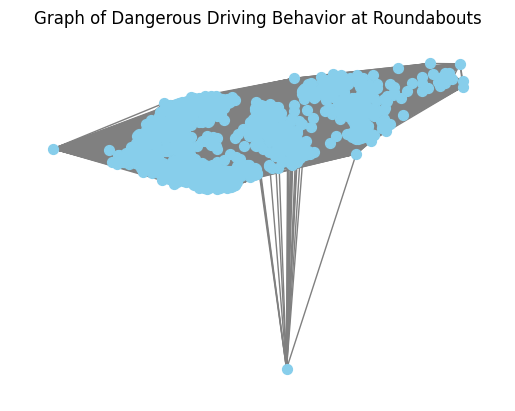

In [62]:
#Visualize Graph
# Create a layout for the nodes
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=50)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Label nodes with their location (you can customize labels as needed)
#labels = {node: node for node in G.nodes()}
#nx.draw_networkx_labels(G, pos, labels, font_size=8)

# Set plot options
plt.title("Graph of Dangerous Driving Behavior at Roundabouts")
plt.axis('off')

# Show the plot
plt.show()

Analyzing potential DDB based on accident data's similarity etc.